
[TF-IDF Baseline]
Precision@10: 0.0439
Recall@10: 0.1931
NDCG@10: 0.2153
Evaluated_Items: 3735


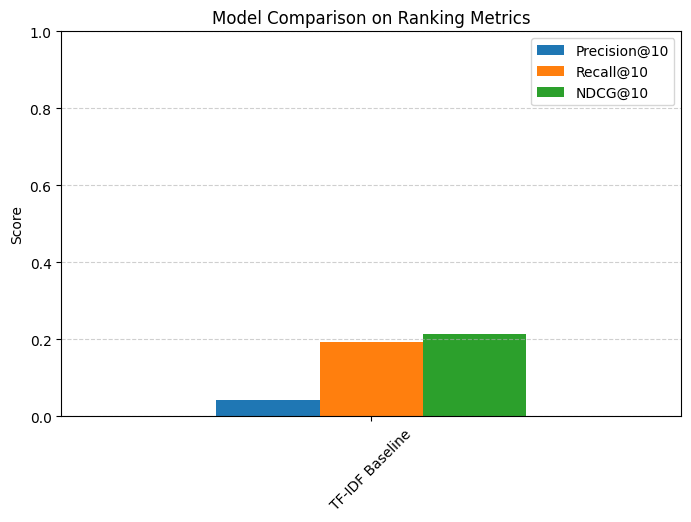

In [2]:
import pandas as pd
import numpy as np
import json, re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_title(text):
    text = str(text).lower().strip()
    text = re.sub(r'^\d+\.\s*', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def parse_similar(x):
    if not isinstance(x, str):
        return []
    try:
        return [clean_title(i) for i in json.loads(x.replace("'", '"'))]
    except Exception:
        try:
            from ast import literal_eval
            lst = literal_eval(x)
            return [clean_title(i) for i in lst if isinstance(i, str)]
        except Exception:
            return []

def precision_recall_at_k(pred, truth, k=10):
    if not truth:
        return None, None
    pred_k = pred[:k]
    hits = len(set(pred_k) & set(truth))
    return hits / len(pred_k), hits / len(truth)

def ndcg_at_k(pred, truth, k=10):
    rel = [1 if item in truth else 0 for item in pred[:k]]
    if not any(rel):
        return 0.0
    dcg = sum(r / np.log2(i+2) for i, r in enumerate(rel))
    idcg = sum(sorted(rel, reverse=True)[i] / np.log2(i+2) for i in range(len(rel)))
    return dcg / idcg

class RecommenderEvaluator:
    def __init__(self, df, text_col="title", similar_col="similar_questions"):
        self.df = df.copy()
        self.df['clean_title'] = self.df[text_col].apply(clean_title)
        self.df['ground_truth'] = self.df[similar_col].apply(parse_similar)
        self.results = {}

    def evaluate(self, model_name, recommender_fn, k=10, verbose=True):
        precisions, recalls, ndcgs = [], [], []
        tested = 0

        for i in range(len(self.df)):
            gt = self.df.loc[i, 'ground_truth']
            if not gt:
                continue
            pred = recommender_fn(i, k)
            p, r = precision_recall_at_k(pred, gt, k)
            n = ndcg_at_k(pred, gt, k)
            if p is not None:
                precisions.append(p)
                recalls.append(r)
                ndcgs.append(n)
                tested += 1

        summary = {
            "Precision@10": np.mean(precisions),
            "Recall@10": np.mean(recalls),
            "NDCG@10": np.mean(ndcgs),
            "Evaluated_Items": tested
        }

        self.results[model_name] = summary
        if verbose:
            print(f"\n[{model_name}]")
            for k, v in summary.items():
                print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
        return summary

    def compare_models(self):
        if not self.results:
            print("No models evaluated yet.")
            return

        df_results = pd.DataFrame(self.results).T
        df_results = df_results[['Precision@10','Recall@10','NDCG@10']]

        df_results.plot(kind='bar', figsize=(8,5))
        plt.title("Model Comparison on Ranking Metrics")
        plt.ylabel("Score")
        plt.ylim(0,1)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
        return df_results


if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv(r"C:\Users\yashw\PycharmProjects\PythonProject4\data\processed\preprocessed_data.csv")
    df['topic_tags'] = df['topic_tags'].fillna('').astype(str)
    df['combined_text'] = (
        df['title'].astype(str) + " " +
        df['topic_tags'].astype(str)
    )

    # Fit TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['combined_text'])

    # Define baseline recommender
    def tfidf_recommender(idx, k=10):
        sim_scores = cosine_similarity(X[idx], X).flatten()
        sim_scores[idx] = 0
        top_idx = sim_scores.argsort()[-k:][::-1]
        return [clean_title(df.iloc[i]['title']) for i in top_idx]

    # Initialize evaluator and run
    evaluator = RecommenderEvaluator(df)
    evaluator.evaluate("TF-IDF Baseline", tfidf_recommender, k=10)
    evaluator.compare_models()
